In [55]:
# ======== importing modules ========
from pytransit import MandelAgol
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
import pandas as pd

fs = 22; ms = 4 #fontsize, markersize

#========== Karen's inverse weighted binning function =======
def Bin_func(time,flux,error,binsize):

    good = np.where(np.isfinite(time)) # finding where values are finite and "Not a Number (NaN)" or +/- infinite (inf)
    timefit = time[good] 
    fluxfit = flux[good] #using indices where values are finite, find where times, flux and errors are also finite
    errfit  = error[good]
    timemax = np.max(timefit) #find max time (or last time measurement)
    timemin = np.min(timefit) #find min time (or first time measurement)
    npoints = len(timefit)    #find number of data points
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days to nearest interger
    bintime = np.full((nbins,), np.nan) 
    binflux = np.full((nbins,), np.nan) #creating an empty array full of NaNs to fill in below
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )] #with given binsize, searching over smaller areas (aka windows) (t-window) to (t+window)
        if tobin[0] != -1:
    #     inverse variance weighted means; read about here: https://en.wikipedia.org/wiki/Inverse-variance_weighting
    
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime)) #checking again for NaNs and infs that might be created by previous step
    bintime = bintime[good2]
    binflux = binflux[good2] 
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr #here you have binned data with averaged values based on the bin sizes you've selected


def GLS(time,flux,fluxerror):
    from PyAstronomy.pyTiming import pyPeriod
    # Compute the GLS periodogram with default options.
    # Choose Zechmeister-Kuerster normalization explicitly
    
#     clp = pyPeriod.Gls((time, flux, fluxerror), norm="ZK", verbose=True)
    clp = pyPeriod.Gls((time, flux, fluxerror), norm="chisq", verbose=True)    

    # Get index associated with highest power
    ifmax = np.argmax(clp.power)
    # and highest power and associated frequency
    pmax = clp.power[ifmax]
    fmax = clp.freq[ifmax]
    # Convert frequency into period
    hpp = 1./fmax
#     print("Highest-power period: ", hpp)

    # Calculate sine wave associated with 'best-fit' frequency
    bestSine = clp.sinmod(time)
    
    return bestSine, 1./fmax

In [70]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
path = '/Users/felizd/Desktop/Felix/TESSdata/' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print "number of files: ",len(data) #number of files
print " "

for x in range(len(data)):
    print data[x][37:] #excludes first 37 characters of pathname
    print ""

number of files:  8
 
147284933_sector01_1_1.lc

197766674_sector01_2_4.lc

219338655_sector01_2_2.lc

289936047_sector01_1_4.lc

308613184_sector01_4_3.lc

339578053_sector01_2_2.lc

426018816_sector01_3_3.lc

441409656_sector01_1_4.lc



In [72]:
print data[2]#[37:-3]

d = np.transpose(np.loadtxt(data[2]))
t = d[0]
m = d[1]/np.nanmean(d[1]) #normalized
e = d[2]
f = 10.0**(m/-2.5)/np.mean(10.0**(m/-2.5)) #converting from mag to flux and normalizing

binsize = (1./24.0); print binsize

print "don't worry about errors, some things are being divided by 0 but we take care of that"

print "don't worry about errors, some things are being divided by 0 but we take care of that"



print "binning data"
bint,binm,binfe = Bin_func(t,m,e, binsize) #binning data
binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5)) # converting from magnitude to flux

/Users/felizd/Desktop/Felix/TESSdata/219338655_sector01_2_2.lc
0.0416666666667
don't worry about errors, some things are being divided by 0 but we take care of that
don't worry about errors, some things are being divided by 0 but we take care of that
binning data


/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

comparing cut data with cut and binned data


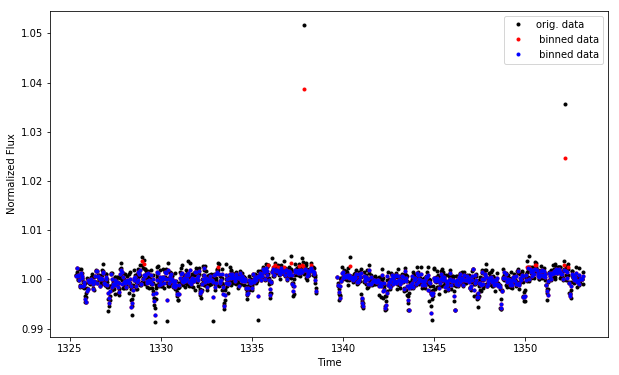

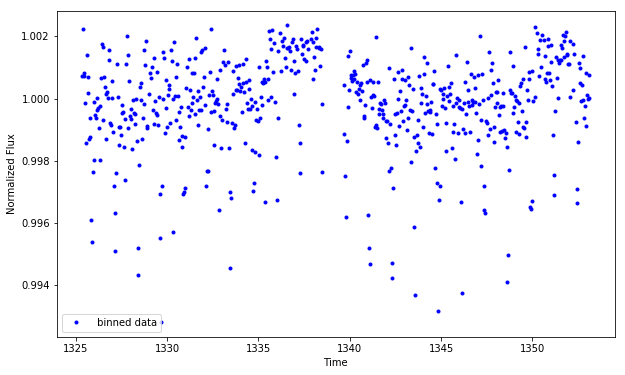

In [76]:
cut = np.where(binf< (np.mean(binf)+np.std(binf)))[0] #cutting only data above 1 std above the mean

print "comparing cut data with cut and binned data"
plt.figure(figsize=(10,6))
plt.plot(t, f,marker='.',color='black',linestyle='none',label="orig. data",zorder=0)
plt.plot(bint,binf,marker='.',color='r',linestyle='none',label=" binned data",zorder=1)
plt.plot(bint[cut],binf[cut],marker='.',color='b',linestyle='none',label=" binned data",zorder=2)
plt.xlabel("Time")
plt.ylabel("Normalized Flux")
plt.legend(loc='best') 
plt.savefig(str(data[2][37:-3])+"_lightcurve.png")
plt.show()




plt.figure(figsize=(10,6))
plt.plot(bint[cut],binf[cut],marker='.',color='b',linestyle='none',label=" binned data",zorder=2)
plt.xlabel("Time")
plt.ylabel("Normalized Flux")
plt.legend(loc='best') 
plt.show()

np.savetxt(str(data[2][37:-3])+"_binned.txt", zip(t[cut],m[cut],e[cut]))

In [77]:
print "Let's start a BLS search:"
print "first we need to calculate our input parameters:"

Let's start a BLS search:
first we need to calculate our input parameters:


In [78]:


duration = t[cut][-1] - t[cut][0] #duration of data set = last - first data point of light curve

#min, max periods:
Pmin = 1.01
Pmax =  31.0

#min, max fractional transit duration (q = transit duration / orbital period)
qmin = 0.01
qmax = 0.1

Nfreq = round(4.0*duration*(1./Pmin - 1./Pmax)/qmin,1) #number of frequencies to fix boxes to ; rounds to nearest decimal
Nbins = 2.0/qmin # number of phase bins to fold our data over
Npeaks = 4 #number of top peaks in power spectrum to report

print "duration of binned light curved:", duration
print "max, min orbital period: ", Pmin, Pmax
print "max, min fractional transit duration: ", qmin, qmax
print "number of frequencies: ", Nfreq
print "number of phase bins: ", Nbins

TIC = data[2][37:-3] #TESS ID number of this object

print " "
print "see BLS.sh to see how VARTOOLS syntax works"
print ('sh BLS.sh '+str(data[2][37:-3])+"_binned.txt"+' '+str(qmin)+" "+str(qmax)+" "+str(Pmin)+" "+str(Pmax)+" "+str(Nfreq)+ " "+str(Nbins)+" "+str(Npeaks)+" "+str(TIC) ) 


os.system('sh BLS.sh '+str(data[2][37:-3])+"_binned.txt"+' '+str(qmin)+" "+str(qmax)+" "+str(Pmin)+" "+str(Pmax)+" "+str(Nfreq)+ " "+str(Nbins)+" "+str(Npeaks)+" "+str(TIC)) 

print ""
print "now to load in results"

duration of binned light curved: 14.479370999999901
max, min orbital period:  1.01 31.0
max, min fractional transit duration:  0.01 0.1
number of frequencies:  5547.6
number of phase bins:  200.0
 
see BLS.sh to see how VARTOOLS syntax works
sh BLS.sh 219338655_sector01_2_2_binned.txt 0.01 0.1 1.01 31.0 5547.6 200.0 4 219338655_sector01_2_2

now to load in results


printing top peaks and its orbital periods
1.26701294

plotting BLS power spectrum: 


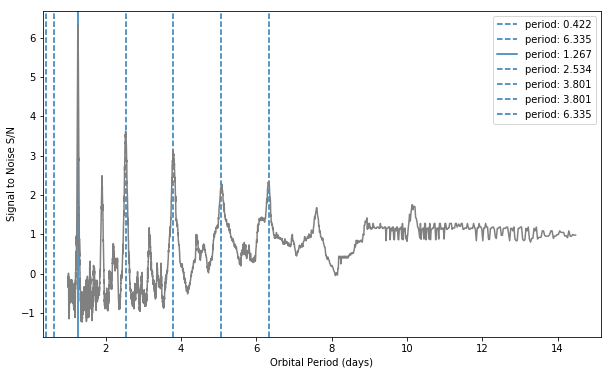

 phase folding
load in BLS model for top peak


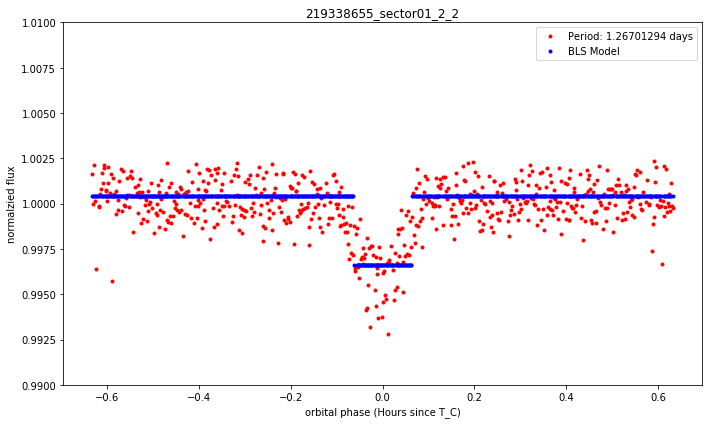

In [80]:
BLS_output = np.loadtxt("TESSdata/"+str(TIC)+"_BLS_output.txt", usecols=[2], skiprows=1) #using 2 columns of data, skipping 1st line

print "printing top peaks and its orbital periods"
for i in range(1): 
    print BLS_output[0::18][:-1][i]
    print ""
    
BLS_Period = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls"))[0]
BLS_SN = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls"))[1]

print "plotting BLS power spectrum: "

plt.figure(figsize=(10,6))
plt.plot(BLS_Period,BLS_SN,color='grey',zorder=1)
plt.xlabel("Orbital Period (days)")
plt.ylabel("Signal to Noise S/N")
#plot vertical lines where multiples (1/3,1/2,2,3,4,5) of top peak's period in power spectrum occur:
plt.axvline(x=BLS_output[0::18][:-1][0]/3.,label = "period: "+str(np.round(BLS_output[0::18][:-1][0]/3.,3)),zorder=0,linestyle='--')
plt.axvline(x=BLS_output[0::18][:-1][0]/2.,label = "period: "+str(np.round(BLS_output[0::18][:-1][0]/.2,3)),zorder=0,linestyle='--')
plt.axvline(x=BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0],3)),zorder=0,linestyle='-')
plt.axvline(x=2*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*2,3)),zorder=0,linestyle='--')
plt.axvline(x=3*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*3,3)),zorder=0,linestyle='--')
plt.axvline(x=4*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*3,3)),zorder=0,linestyle='--')
plt.axvline(x=5*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*5,3)),zorder=0,linestyle='--')
plt.legend(bbox_to_anchor=(1,1)) #bbox_to_anchor places legend outside the plot
plt.show()



print" phase folding"
t0  = BLS_output[1::18][:-1][0] # a reference time output by BLS. The 1::18 means gives me the 2nd output every 18 lines. 
p = BLS_output[0::18][:-1][0]   # the [:-1] is there to remove the last entry to avoid errors. The [0] gives the output after 
#                               # this index slicing
pf= ((bint[cut] - t0  + p/2.0) % p)- p/2.0



print "load in BLS model for top peak"

bls_model = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls.model"))
time_model = bls_model[0]
mag_model = bls_model[2]
flux_model = 10.0**(mag_model/-2.5)/np.mean(10.0**(mag_model/-2.5))
phase_model = np.array(((time_model - t0  + p/2.0) % p)- p/2.0 )



# binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5))

plt.figure(figsize=(10,6))
plt.plot(pf,binf[cut],marker='.',c='r',linestyle='none',label='Period: '+str(p)+" days",zorder=0)
plt.plot(phase_model,flux_model,marker='.',c='b',linestyle='none',label='BLS Model',zorder=1)
# plt.gca().invert_yaxis()
plt.ylabel("normalzied flux")
# plt.xlabel("orbital phase (JD since T_C)")
plt.xlabel("orbital phase (Hours since T_C)")
plt.ylim(0.99,1.01)
plt.title(str(TIC))
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig(str(TIC)+".png")
plt.show()


removing waviness using a General Lomb Scargle (sine wave) fit: 
0.00347222222222


/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/felizd/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

No output of frequency error.
Increase frequency range to sample the peak maximum.
Generalized LS - statistical output
-----------------------------------
Number of input points:      618   
Weighted mean of dataset:    1.000391
Weighted rms of dataset:     0.004061
Time base:                   1.265445
Number of frequency points:  3089  

Maximum power p [chisq]:  1.308917
RMS of residuals:      0.003940
  Mean weighted internal error:  0.088228
Best sine frequency:   0.079024 +/-  nan
Best sine period:      12.654452 +/-  nan
Amplitude:             0.063314 +/-  0.000224
Phase (ph):           -0.294965 +/-  0.000563
Phase (T0):            3.100085 +/-  0.007129
Offset:                1.062639 +/-  0.000158
-----------------------------------


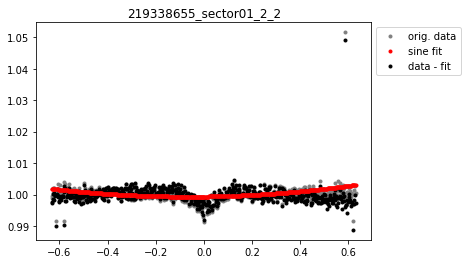

so this isn't a great fit...


In [82]:
print 'removing waviness using a General Lomb Scargle (sine wave) fit: '
binsize = 5./(24.0*60); print binsize
bint,binf,binfe = Bin_func(t[cut],f[cut],e[cut],binsize)
binpf= ((bint - t0  + p/2.0) % p)- p/2.0

glssinu,glspu = GLS(binpf,binf,binfe) #see GLS definition above. This fits the best sine wave it can to the data.
fit1 = binf-glssinu+1
plt.plot(binpf,binf,marker='.',linestyle='none',color='grey',zorder=0,label='orig. data')
plt.plot(binpf,glssinu,marker='.',linestyle='none',color='red',zorder=2,label='sine fit')
plt.plot(binpf,fit1,marker='.',linestyle='none',color='black',zorder=1,label='data - fit')
plt.legend(loc='best',bbox_to_anchor=(1,1))
plt.title(str(TIC))
plt.show()

print "so this isn't a great fit..."


In [83]:
print "In the future, perhaps we should only try removing waviness by taking out the transit events. Let's talk about this more."

In the future, perhaps we should only try removing waviness by taking out the transit events. Let's talk about this more.
